In [ ]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [4]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [5]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [6]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [7]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [8]:
# # Review unperturbed elements
# elts_ast

In [9]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [10]:
# Choose which elements to search on
# elts = elts_pert
elts = elts_ast

In [11]:
# Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [12]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [13]:
# Review nearest asteroid to these candidate elements
# elts_near

In [14]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [15]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [16]:
elts

,element_id,a,e,inc,Omega,omega,f,epoch
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0
...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0


In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004080,-0.057300,-0.982042,0.179751,2.234078,0.010624,2191.408734,0.999944,0.092645,False
1,73603,733,b'ZTF18ablwzmb',609167834815015007,7226,58363.167836,265.761064,-13.509195,18.339701,-0.071871,...,0.003999,-0.055041,-0.979702,0.192757,2.397172,0.027352,5641.954857,0.999626,0.614061,False
2,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004080,-0.057300,-0.982042,0.179751,2.234078,0.016809,3467.151428,0.999859,0.231907,False
3,73605,733,b'ZTF18ablwzmb',584189894815015004,4646,58338.189896,265.761079,-13.509107,16.892200,-0.071871,...,0.004126,-0.045072,-0.984663,0.168544,2.138928,0.027030,5575.548058,0.999635,0.599691,False
4,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003825,0.000919,-0.977996,0.208622,2.703478,0.005450,1124.103915,0.999985,0.024378,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322909,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.025126,5182.803024,0.999684,0.518186,False
322910,5651378,324582,b'ZTF20aaqvkyo',1150185754815015007,96635,58904.185752,42.122572,29.195466,18.337299,0.647485,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.029094,6001.222051,0.999577,0.694749,False
322911,5651434,324582,b'ZTF20aaqvkus',1150185310315015002,96634,58904.185313,43.256211,29.954124,19.257601,0.631015,...,-0.001541,0.627610,0.750725,0.206200,2.981912,0.017707,3652.453216,0.999843,0.257358,False
322912,5651513,324582,b'ZTF20aaqvlna',1150185755115015011,96635,58904.185752,42.388038,28.228923,19.199400,0.650751,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.030306,6251.306560,0.999541,0.753854,False


In [19]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   322914   (     5046)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :    2908.12
Sqrt(batch_obs):      71.03
Mean t_score   :      45.02


In [21]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [22]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [23]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [24]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,10,0.008727,0.034905,16.5
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,10,0.008727,0.034905,16.5
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,10,0.008727,0.034905,16.5
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,10,0.008727,0.034905,16.5
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,10,0.008727,0.034905,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,10,0.008727,0.034905,16.5
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0,10,0.008727,0.034905,16.5
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,10,0.008727,0.034905,16.5
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,10,0.008727,0.034905,16.5


## Train on Perturbed Elements: Learn Mixture Parameters

In [25]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [26]:
# Training parameters
learning_rate = 2.0**-15
clipnorm = 1.0
save_at_end: bool = True

In [27]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [28]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     3.13  :   0.00 :  0.499750 :  1799.10 : 2.000000
Std  :     1.42  :   0.00 :  0.000000 :     0.00 : 0.000000
Min  :     0.16  :   0.00 :  0.499750 :  1799.10 : 2.000000
Max  :     6.42  :   0.00 :  0.499750 :  1799.10 : 2.000000
Trained for 0 batches over 0 epochs and 0 episodes.


In [ ]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [35]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=15000,
    learning_rate=2.0**-12,
)


Training episode 26: Epoch  130, Batch  13000
effective_learning_rate=3.052e-05, training_time 397 sec.
Train on 6400 samples
Epoch 131/135
6400/6400 [==============================] - 2s 361us/sample - loss: -72275.2679
Epoch 132/135
6400/6400 [==============================] - 2s 351us/sample - loss: -72970.4834
Epoch 133/135
6400/6400 [==============================] - 2s 348us/sample - loss: -73664.2222
Epoch 134/135
6400/6400 [==============================] - 2s 349us/sample - loss: -74356.5694
Epoch 135/135
6400/6400 [==============================] - 2s 355us/sample - loss: -75047.5353
Geom Mean Resolution: 0.008643 degrees (  31.1 arc seconds)
Mean Hits          :    163.17
Mean Log Likelihood:    959.23

Training episode 27: Epoch  135, Batch  13500
effective_learning_rate=3.052e-05, training_time 425 sec.
Train on 6400 samples
Epoch 136/140
6400/6400 [==============================] - 2s 355us/sample - loss: -75736.9111
Epoch 137/140
6400/6400 [=============================

In [42]:
# Report results
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :  1086.71  : 163.06 :  0.005948 :    21.41 : 2.000000
Std  :   124.36  :  13.40 :  0.000440 :     1.58 : 0.000000
Min  :   854.31  : 147.82 :  0.005020 :    18.07 : 2.000000
Max  :  1424.54  : 200.92 :  0.006751 :    24.30 : 2.000000
Trained for 15000 batches over 150 epochs and 30 episodes.


In [44]:
# Save the model
model.save_state()

## Review Results Graphically

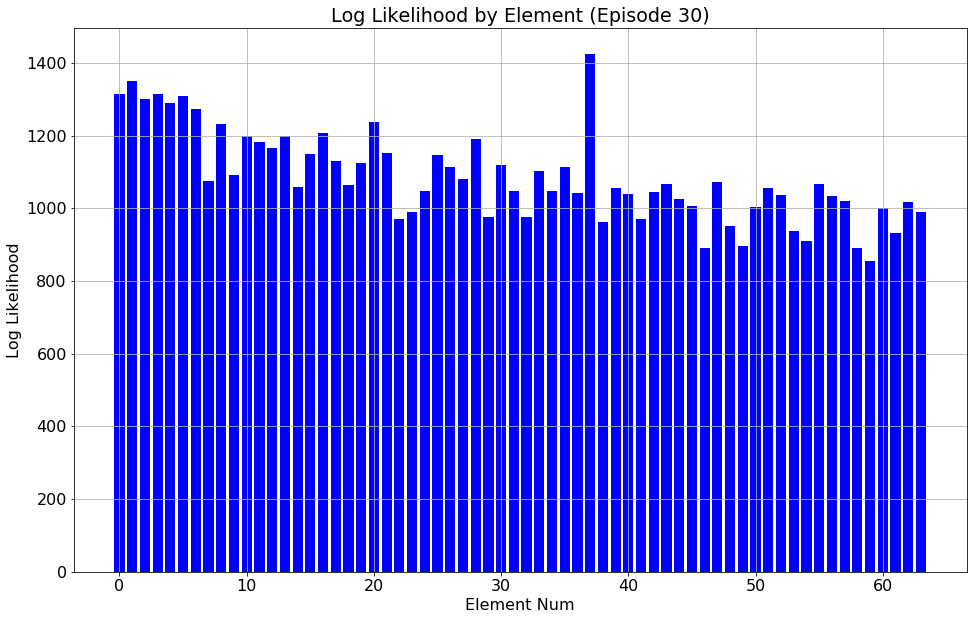

In [36]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

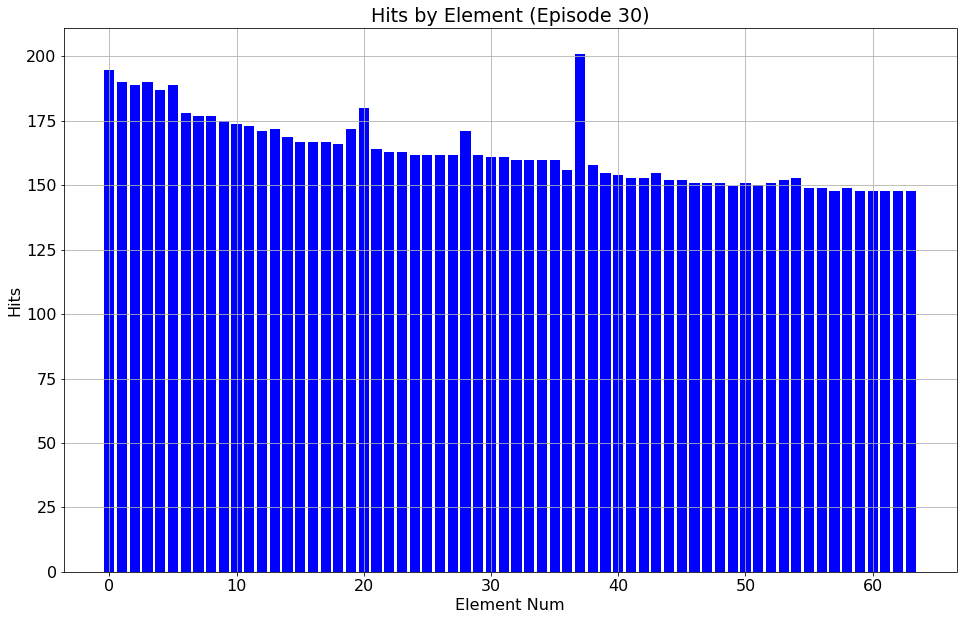

In [37]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

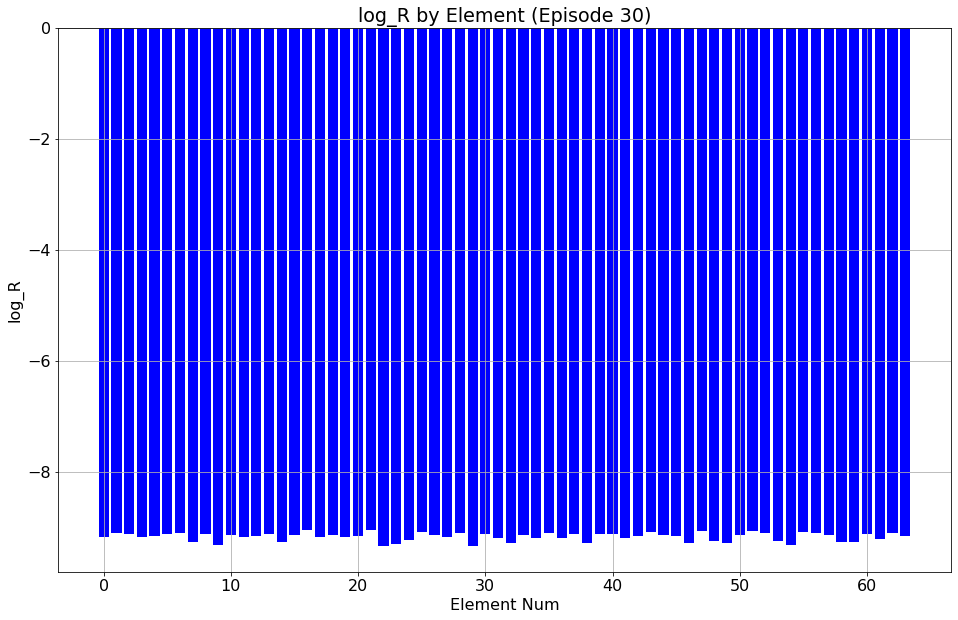

In [38]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('log_R', sorted=False)

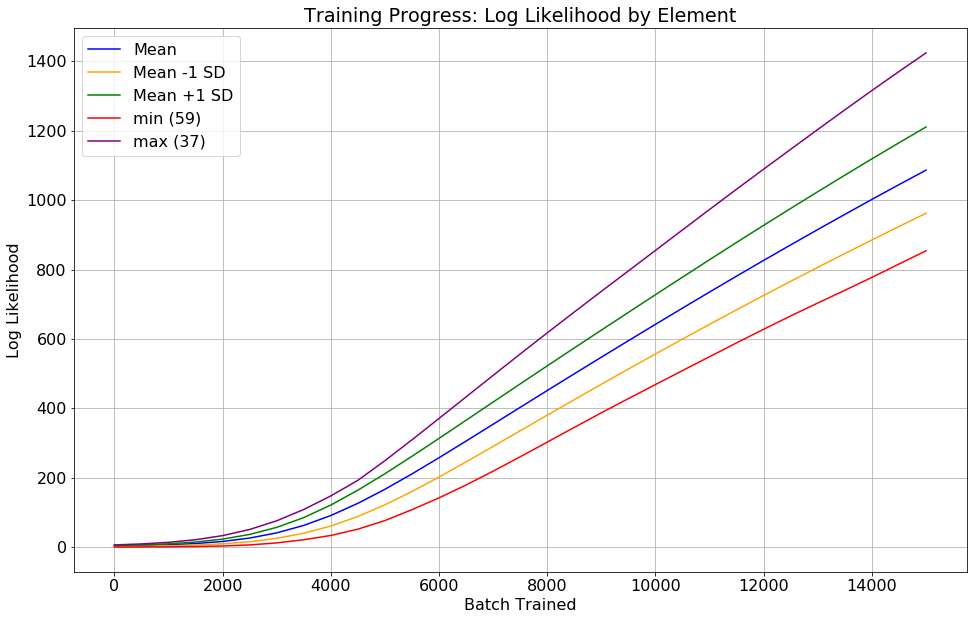

In [39]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

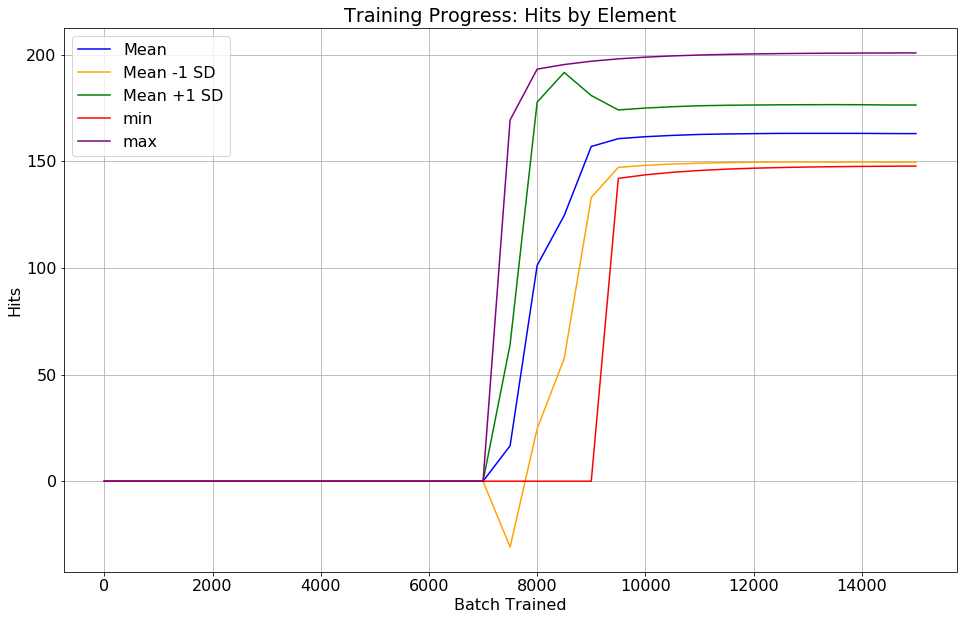

In [40]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [41]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Sub: Dst tensor is not initialized. [Op:Sub] name: sub/

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
# # Review asteroids nearest to the fitted elements
# elts_near

In [ ]:
# Review fitted elements including nearest asteroid
elts_fit

In [ ]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
elts_fit[mask]

In [ ]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
model.elts_near_ast

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)